# RNN Text Classification

- Predict the sentiment of IMDB movie reviews

# 1)- Importing key modules

In [0]:
from pathlib import Path

import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.feature_extraction.text import CountVectorizer
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, tqdm_notebook

In order to perform deep learning on a GPU (so that everything runs super quick!), CUDA has to be installed and configured. Fortunately, Google Colab already has this set up, but if you want to try this on your own GPU, you can [install CUDA from here](https://developer.nvidia.com/cuda-downloads). Make sure you also [install cuDNN](https://developer.nvidia.com/cudnn) for optimized performance.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# 2)- Loading data

This is a dataset of positive and negative IMDB reviews. We can download the data from a public Google Drive folder.

In [0]:
DATA_PATH = 'data/imdb_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz',
        dest_path=DATA_PATH,
    )

In [4]:
# View some example records
pd.read_csv(DATA_PATH).sample(5)

review  label
12329  I was looking forward to watching this film an...      0
14020  Jolene (Heather Graham) operates a night club ...      1
56149  If I hadn't read his name on the DVD cover, I ...      0
52672  It was the Sixties, and anyone with long hair ...      0
22757  "From C. Jay Cox, the writer of the hit comedy...      1

In [0]:
df=pd.read_csv(DATA_PATH)

In [6]:
df.shape

(62155, 2)

# 3)- Preprocess the text

In [0]:
vectorizer = CountVectorizer(stop_words='english', max_df=0.99, min_df=0.015)

In [0]:
sequences = vectorizer.fit_transform(df.review.tolist())

In [9]:
sequences

<62155x1103 sparse matrix of type '<class 'numpy.int64'>'
	with 3101989 stored elements in Compressed Sparse Row format>

In [10]:
print(pd.DataFrame(sequences).head(2))

                                                   0
0    (0, 640)\t1\n  (0, 637)\t1\n  (0, 343)\t1\n ...
1    (0, 145)\t3\n  (0, 777)\t2\n  (0, 173)\t1\n ...


In [0]:
token2idx = vectorizer.vocabulary_

**All in one**

In [0]:
class Sequences(Dataset):
    def __init__(self, path, max_seq_len):
        self.max_seq_len = max_seq_len
        df = pd.read_csv(path)
        vectorizer = CountVectorizer(stop_words='english', min_df=0.015)
        vectorizer.fit(df.review.tolist())
        
        self.token2idx = vectorizer.vocabulary_
        self.token2idx['<PAD>'] = max(self.token2idx.values()) + 1 # for removing zeros

        tokenizer = vectorizer.build_analyzer()
        self.encode = lambda x: [self.token2idx[token] for token in tokenizer(x)
                                 if token in self.token2idx]
        self.pad = lambda x: x + (max_seq_len - len(x)) * [self.token2idx['<PAD>']]
        
        sequences = [self.encode(sequence)[:max_seq_len] for sequence in df.review.tolist()]
        sequences, self.labels = zip(*[(sequence, label) for sequence, label
                                    in zip(sequences, df.label.tolist()) if sequence])
        self.sequences = [self.pad(sequence) for sequence in sequences]

    def __getitem__(self, i):
        assert len(self.sequences[i]) == self.max_seq_len
        return self.sequences[i], self.labels[i]
    
    def __len__(self):
        return len(self.sequences)

In [0]:
dataset = Sequences(DATA_PATH, max_seq_len=128)

In [14]:
len(dataset.token2idx)

1104

In [0]:
def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    target = torch.FloatTensor([item[1] for item in batch])
    return inputs, target

batch_size = 2048
train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate)

**What is collate?**

https://discuss.pytorch.org/t/how-to-use-collate-fn/27181/2

# 4)- GRU Model Building

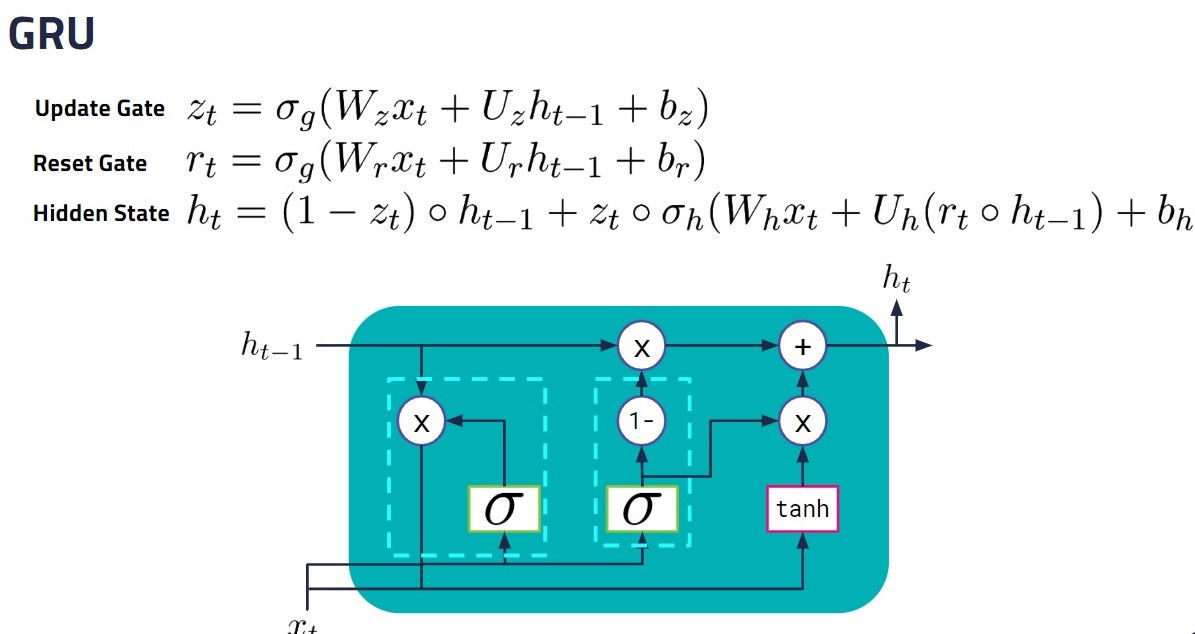

In [16]:
from IPython.display import Image
Image("GRU.jpg")

In [0]:
class RNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        batch_size,
        embedding_dimension=100,
        hidden_size=128, 
        n_layers=1,
        device='cuda',
    ):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.device = device
        self.batch_size = batch_size
        
        self.encoder = nn.Embedding(vocab_size, embedding_dimension)
        self.rnn = nn.GRU(
            embedding_dimension,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
        )
        self.decoder = nn.Linear(hidden_size, 1)
        
    def init_hidden(self):
        return torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device)
    
    def forward(self, inputs):
        # Avoid breaking if the last batch has a different size
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
            
        encoded = self.encoder(inputs)
        output, hidden = self.rnn(encoded, self.init_hidden())
        output = self.decoder(output[:, :, -1]).squeeze()
        return output

In [18]:
model = RNN(
    hidden_size=128,
    vocab_size=len(dataset.token2idx),
    device=device,
    batch_size=batch_size,
)
model = model.to(device)
model

RNN(
  (encoder): Embedding(1104, 100)
  (rnn): GRU(100, 128, batch_first=True)
  (decoder): Linear(in_features=128, out_features=1, bias=True)
)

# 5)- Train the model



In [0]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)# Adam: Dynmaically change learning rate

**Binary crossentropy(BCEWithLogitsLoss)**<br>

**It's called Binary Cross-Entropy Loss because it sets up a binary classification problem between C′=2 classes for every class in C i.e Positive or negative sentiment**

In [20]:
model.train()
train_losses = []
for epoch in range(20): # epoch size
    progress_bar = tqdm_notebook(train_loader, leave=False)
    losses = []
    total = 0
    for inputs, target in progress_bar:
        inputs, target = inputs.to(device), target.to(device
                                                     )
        model.zero_grad()
        
        output = model(inputs)
    
        loss = criterion(output, target)
        
        loss.backward()
              
        nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        losses.append(loss.item())
        total += 1
    
    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)

    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')

Epoch #1	Train Loss: 0.811


Epoch #2	Train Loss: 0.723


Epoch #3	Train Loss: 0.711


Epoch #4	Train Loss: 0.699


Epoch #5	Train Loss: 0.670


Epoch #6	Train Loss: 0.608


Epoch #7	Train Loss: 0.585


Epoch #8	Train Loss: 0.512


Epoch #9	Train Loss: 0.490


Epoch #10	Train Loss: 0.456


Epoch #11	Train Loss: 0.441


Epoch #12	Train Loss: 0.424


Epoch #13	Train Loss: 0.411


Epoch #14	Train Loss: 0.401


Epoch #15	Train Loss: 0.391


Epoch #16	Train Loss: 0.384


Epoch #17	Train Loss: 0.376


Epoch #18	Train Loss: 0.370


Epoch #19	Train Loss: 0.363


Epoch #20	Train Loss: 0.358


# 6)- Prediction

In [0]:
def predict_sentiment(text):
    model.eval()
    with torch.no_grad():
        test_vector = torch.LongTensor([dataset.pad(dataset.encode(text))]).to(device)
        
        output = model(test_vector)
        prediction = torch.sigmoid(output).item()

        if prediction > 0.5:
            print(f'{prediction:0.3}: Positive sentiment')
        else:
            print(f'{prediction:0.3}: Negative sentiment')

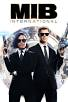

In [22]:
Image("men_in_black.jpg")

In [23]:
test_text = """
Men in Black: International starring Chris Hemsworth and Tessa Thompson appears uninspiring, staid and predictable but is engaging in parts. 
"""
predict_sentiment(test_text)

0.23: Negative sentiment


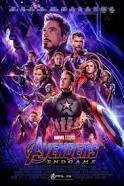

In [24]:
Image("Avengers.jpg")

In [25]:
test_text = """
Phenomenally entertaining and a masterpiece!!! The Russo brothers nailed it again!!! I'm so grateful they're directing these movies. It makes them so much better and everything is so well thought out. Love it!! It's so on-point. Has everything drama, suspense, some 
funny comedy moments, full of adventure, mystery, and impressive action sequences I've ever seen. It's the most best superhero movie I've ever seen in my life. The acting was superb and convincing. 
Very well directed, written and acted.
"""
predict_sentiment(test_text)

0.979: Positive sentiment


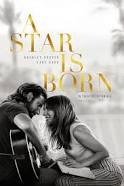

In [26]:
Image("star_is_born.jpg")

In [27]:
test_text = """
An absolutely incredible movie that looks at important issues like substance abuse, suicide and what fame can do  to a person. Lady Gaga and Bradley Cooper truly deliver strong emotions in their performances throughout. The  soundtrack for the film is so 
heart warming and listening to the songs takes you back and reminds you of the story of  Jackson and Ally.
"""
predict_sentiment(test_text)

0.988: Positive sentiment
